In [381]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import pickle

import skyscraper
import gymnasium

from copy import deepcopy
from time import time

# Part 2 - Report

### Exercise 4 - Feature Engineering

We will consider the *Mountain-Cart* environment from the **gymniasium** library, which we will run for 1000 steps.

In [382]:
# Instantiate the mountain cart environment with the correct max steps
env = gymnasium.make('MountainCar-v0',
                    max_episode_steps = 1000)

To decide the discretization step $\Delta$ we observe that the observation space is bounded by $[-1.2, 0.6]$ for the x-position of the car, and $[-0.07, 0.07]$ for the velocity of the car.

Therefore a reasonable discretization step could be $\Delta=0.01$.

We create a function of turning the continuous states into these discrete states and use Q-learning to try to learn $\pi^*$.

In [383]:
def discretize(state, delta):
    # Discretize with Delta = 0.01
    return np.round(state / delta) * delta

def indexOf(state, delta):
    # Turn state into Q index
    return np.array(np.round((state + np.array([1.2, 0.07])) / delta), dtype=np.int64)

In [384]:
def Q_learn(env, episodes, delta, gamma, alpha, epsilon, epsilon_decay):
    positions, velocities, actions = *indexOf(np.array([0.6, 0.07]), delta), 3
    Q = np.zeros((positions, velocities, actions))
    
    # Set the Goal values as 1
    for position in np.arange(0.5, 0.6, delta):
        index = indexOf((position, 0), delta)
        Q[index[0]] = np.ones((velocities, actions))

    # Store running mean of rewards for later comparison
    running_mean, running_means = 0,  []
    for _ in range(episodes):
        total_episode_reward = 0
        observation, info = env.reset()
        terminated = truncated = False
        while not (terminated or truncated):
            # Discretize the current state and get the next action
            state = discretize(observation, delta)
            state_index = indexOf(state, delta)
            action = np.argmax(Q[state_index[0], state_index[1]]) if np.random.uniform() < (1 - epsilon) else np.random.randint(3)

            # Perform the action and get the next discretized state
            observation, reward, terminated, truncated, info = env.step(action)
            new_state = discretize(observation, delta)
            new_state_index = indexOf(new_state, delta)
        
            delta_π_Q = reward + gamma * np.max(Q[new_state_index[0], new_state_index[1]]) - Q[state_index[0], state_index[1]][action]
            Q[state_index[0], state_index[1]][action] += alpha * delta_π_Q

            total_episode_reward += reward
        
        # Store reward for this episode
        running_mean += (total_episode_reward - running_mean) / (len(running_means)+1)
        running_means.append(running_mean)
        epsilon *= epsilon_decay
    
    return Q, running_means

In [385]:
# Hyperparameters
epsilon = 0.9
epsilon_decay = 0.995
gamma = 0.99
alpha = 0.15

episodes = 10000

# Lets use a range of discretization steps and see which is the best
discretizations = [0.05, 0.01, 0.005, 0.001]

# Use Q-learning to learn the optimal policy π
Qs, mean_rewards = [], []
for delta in discretizations:
    Q, running_mean = Q_learn(env, episodes, delta, gamma, alpha, epsilon, epsilon_decay)
    Qs.append(Q)
    mean_rewards.append(running_mean)

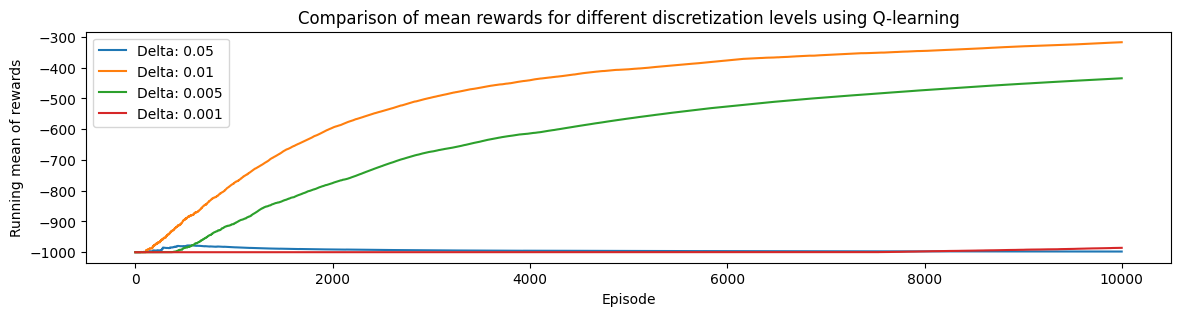

In [386]:
# Let's plot the different reward distributions to see what 
# discretization level works best
plt.figure(figsize=(14, 3))
for delta, rewards in zip(discretizations, mean_rewards):
    plt.plot(rewards, label="Delta: " + str(delta))
plt.xlabel("Episode")
plt.ylabel("Running mean of rewards")

plt.title("Comparison of mean rewards for different discretization levels using Q-learning")
plt.legend()
plt.show()

------------------------------------------
### 2. (*)

From the plot above we can see that the choice of the discretization step $\Delta$ really matters in how fast and well the policy is learned. We can see that 0.5 seems to be too big to be able to accurately represent all the different states, while 0.01 seems to be too small to efficiently learn the policy.

In fact, our choice of 0.1 seems to be the most optimal in this instance, as this consistently has the highest mean reward of them all!

------------------------------------------

------------------------------------------
### 3. (*)

When reflecting on other forms of feature engineering we could consider applying to this problem, we could try to do coarse coding. This is a good way of minimizing the number of possible states we need to store while still keeping a lot of the information and precision about the current state. Here, we could also tune the coarseness and number of circles to our liking.

For this task, the most relevant coarse coding would probably be tile coding, where we tile the space into overlapping tiles which represent our state. This is similar to our discretization step, but as we now could represent our state with several tiles (as they overlap) it will not be exactly the same.

------------------------------------------

### Exercise 5 - Planning

We develop the model $\hat{\mathcal{M}}$ using a tabular solution, where the transition function $f_T(s, a; w_T)$ and the reward function $f_R(s, a; w_R)$ are represented.

In [387]:
# Create the environment
env = gymnasium.make('skyscraper/GridWorld-v0')

The transition function seems to be deterministic from the problem description, therefore the approximated transition function $f_T(s, a; w_T)$ could be simply represented as a single value per state-action pair $(s, a)$.

In [419]:
def DynaQ(env, episodes, simulations, gamma, alpha, epsilon, epsilon_decay):
    # Model approximation
    rows, columns, actions = env.height, env.width, len(env.action_to_direction)
    f_T = np.zeros((rows, columns, actions, 2), dtype=np.int32)
    f_R = np.zeros((rows, columns, actions), dtype=np.int32)

    # Store Q-values
    Q = np.zeros((rows, columns, actions))

    # We need to store previous states and actions
    states_seen, state_samples = set(), []
    actions_taken, action_samples = np.array([[set() for _ in range(columns)] for _ in range(rows)]), [[[] for _ in range(columns)] for _ in range(rows)]

    # Let's populate the model approximation from the data file given
    with open("powered_flight.txt", "r") as f:
        for line in f.readlines():
            i, j, a, r, i_, j_ = map(int, line.strip().split("	"))
            state = (i-1, j-1)
            action = a-1
            reward = r
            new_state = (i_-1, j_-1)
            f_T[state][action] = new_state
            f_R[state][action] = reward

            states_seen.add(state)
            state_samples.append(state)
            actions_taken[state].add(action)
            action_samples[state[0]][state[1]].append(action)

    # We also store steps taken per episode for later comparison
    steps_per_episode = []

    # Run the algorithm
    for _ in range(episodes):
        steps = 0
        observation, info = env.reset()
        terminated = truncated = False
        while not (terminated or truncated):
            steps += 1
            state = (int(observation["agent"]["pos"][0]), int(observation["agent"]["pos"][1]))
            action = np.argmax(Q[state]) if np.random.uniform() < (1 - epsilon) else np.random.randint(actions)

            # Take the action and observe new state
            observation, reward, terminated, truncated, info = env.step(action)
            new_state = (int(observation["agent"]["pos"][0]), int(observation["agent"]["pos"][1]))

            # Update Q
            delta_Q = reward + gamma * np.max(Q[new_state]) - Q[state][action]
            Q[state][action] += alpha * delta_Q

            # Update the model if missing states
            if not state in states_seen:
                states_seen.add(state)
                state_samples.append(state)
            if not action in actions_taken[state]:
                actions_taken[state].add(action)
                action_samples[state[0]][state[1]].append(action)
                f_T[state][action] = new_state
                f_R[state][action] = reward

            # Exploit our knowledge of the model
            for _ in range(simulations):
                state = state_samples[np.random.randint(len(state_samples))]
                action = np.random.choice(action_samples[state[0]][state[1]])

                # Sample reward and new_state from our model approximation
                reward, new_state = f_R[state][action], tuple(f_T[state][action])

                # Use them to learn π
                delta_Q = reward + gamma * np.max(Q[new_state]) - Q[state][action]
                Q[state][action] += alpha * delta_Q
            
        # Decay epsilon
        epsilon *= epsilon_decay

        # Store steps
        steps_per_episode.append(steps)

    # Return our policy π and the steps per episode
    return Q, steps_per_episode

In [428]:
# Hyperparameters for Q-learning
gamma = 0.9
alpha = 0.1
epsilon = 0.5
epsilon_decay = 0.3
episodes = 50

# Number of simulations per timestep when using our approximated model
simulations = 10

# Use DynaQ and try to learn the policy
Q, steps_per_episode = DynaQ(env, episodes, simulations, gamma, alpha, epsilon, epsilon_decay)

{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1


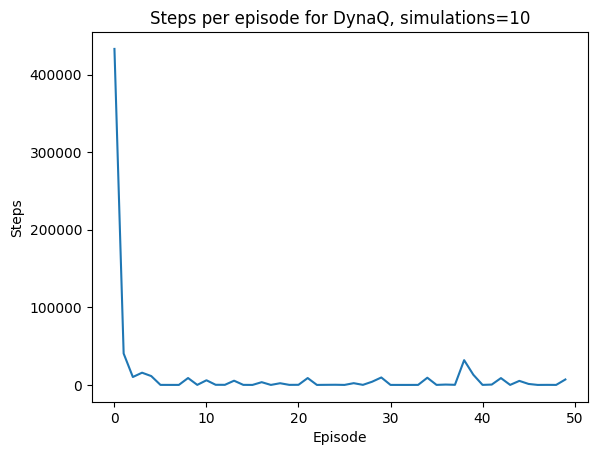

In [431]:
plt.plot(steps_per_episode)
plt.title("Steps per episode for DynaQ, simulations=10")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

Let's plot the optimal trajectory we learned.

{'agent': {'pos': array([14., 54.])}} 1


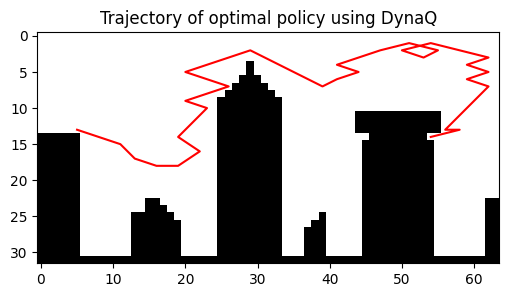

In [430]:
# Sample and store the optimal trajectory
observation, info = env.reset()
trajectory = [(int(observation["agent"]["pos"][0]), int(observation["agent"]["pos"][1]))]
terminated = False
i = 0
while not terminated and i < 20000:
    i += 1
    state = (int(observation["agent"]["pos"][0]), int(observation["agent"]["pos"][1]))
    action = np.argmax(Q[state])
    observation, reward, terminated, truncated, info = env.step(action)
    new_state = (int(observation["agent"]["pos"][0]), int(observation["agent"]["pos"][1]))
    trajectory.append(new_state)

# Plot it
plt.figure(figsize=(14,3))
plt.imshow(env.MAP, cmap="grey")
plt.plot(np.array(trajectory)[:, 1], np.array(trajectory)[:, 0], c="r")
plt.title("Trajectory of optimal policy using DynaQ")
plt.show()

Let's now run DynaQ using a different amount of simulations per timestep.

To compare the results by varying the number of simulations run by the agent we will plot and analyze the number of steps taken per episode. This will give us information about how good and how fast each configuration learns the policy.

In [432]:
no_simulations = [1, 5, 10, 15]
Qs, steps = [], []
for simulations in no_simulations:
    print("Training DynaQ with simulations=" + str(simulations))
    # Train using DynaQ with current configuration
    Q, steps_per_episode = DynaQ(env, episodes, simulations, gamma, alpha, epsilon, epsilon_decay)

    # Store the policy and steps for later comparison
    Qs.append(Q)
    steps.append(steps_per_episode)

Training DynaQ with simulations=1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agent': {'pos': array([14., 54.])}} 1
{'agen

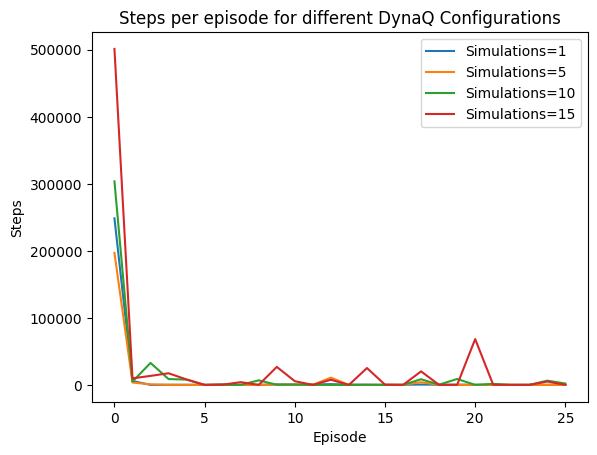

In [436]:
# Let's plot the steps per episode for each trained agent
for simulations, steps_per_episode in zip(no_simulations, steps):
    plt.plot(steps_per_episode[:26], label="Simulations=" + str(simulations))
plt.title("Steps per episode for different DynaQ Configurations")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()

------------------------------------------
### 4. (*)

As we can see, setting simulation count to 15 drastically increases the number of steps needed to reach the target in the first episode, as well as creating bigger extremes in some random fluctuations.

Here, it seems setting simulation count to 5 would be the optimal one, as it has fewer and smaller fluctuations, as well as having the minimum amount of steps before reaching the target in the first episode.

------------------------------------------